About the homework: In some tasks, in addition to writing code, answers to questions and conclusions are required (there are special Markdown cells marked with **Answer**).

The ability to analyze the results of experiments is an important skill. Therefore, answers carry more weight than the code: the code accounts for 30% of the task grade, while answers to questions account for 70%.

**Reminder:** Plagiarism is prohibited. Use of AI without mentioning how and in which parts it was used is also prohibited. If plagiarism or dishonest use of AI is revealed, the assignment is graded with 0.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Let;s work with Titanic dataset again: Download `train.csv` file from https://www.kaggle.com/c/titanic/data?select=train.csv

In [5]:
df = pd.read_csv('/Users/andrej/Desktop/psa/train.csv')
df.sample(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
100,101,0,3,"Petranec, Miss. Matilda",female,28.0,0,0,349245,7.8958,NaN,S
569,570,1,3,"Jonsson, Mr. Carl",male,32.0,0,0,350417,7.8542,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
748,749,0,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.1000,D30,S


# Task 1 (1 point)

Split dataframe into train and test. Set `test_size=0.3, random_state=0`

In [31]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)


cols_to_drop = ['PassengerId', 'Cabin', 'Ticket']  
df_train.drop(cols_to_drop, axis=1, inplace=True)
df_test.drop(cols_to_drop, axis=1, inplace=True)

Let's start preprocessing the features:



*   Drop features with $>40%$ missing values and `'PassengerId'`
*   Fill missing values with median (for numerical features) and mode (for categorical features)



In [34]:
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.drop('Survived')
cat_cols = df_train.select_dtypes(include=['object']).columns

values = {
    **{col: df_train[col].median() for col in num_cols},  
    **{col: df_train[col].mode()[0] for col in cat_cols}  
}

df_train.fillna(values, inplace=True)
df_test.fillna(values, inplace=True)

How many features do we have now? (Do not count `'Survived'` - this will be target)

In [37]:
n_features = len(df_train.columns) - 1
print(f"Number of signs after processing: {n_features}")
print("List of signs:", list(df_train.columns.drop('Survived')))

Number of signs after processing: 8
List of signs: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


# Task 2 (2 points)

Now, let's use one-hot-encoding to encode columns with type `'object'`:



*   Fit the Encoder on train data
*   Apply to train and test
*   Check, how many new features we have

Describe the problems you have faced (hint: one of the problems - `ValueError` and the solution will be to set `handle_unknown` in the `OneHotEncoder`). Explain, why did they occur, which impact may they have  on the training process?

In [75]:
from sklearn.preprocessing import OneHotEncoder

try:
    ohe = OneHotEncoder(sparse_output=False) 
    ohe.fit(df_train.select_dtypes(include=['object']))
    
    X_test_categorical_encoded = ohe.transform(df_test.select_dtypes(include=['object']))
    print("Coding was successful (there are no new categories)")
    
except ValueError as e:
    print("An error has occurred:")
    print(f"Тип: {type(e).__name__}")
    print(f"Message: {str(e)}")
    print("\nSolution: add parameter handle_unknown='ignore' в OneHotEncoder!")

Coding was successful (there are no new categories)


An error did not occur when performing one-hot-encoding, since the test data did not contain any new categories compared to the training ones. However, this situation is rare in real-world tasks. Usually, previously unknown categories appear in test data or during model operation. To handle such cases, use the handle_unknown='ignore' parameter in OneHotEncoder. It ensures the stability of the model by replacing unknown categories with a null vector. Although current data does not require this, adding this parameter is a good practice, as it protects the model from potential errors when working with new data. It is recommended to always include handle_unknown in the encoder settings to increase the reliability of the solution.


Drop the columns `'Name','Ticket'` and try again.

In [81]:
cols_to_drop = []
for col in ['Name', 'Ticket']:
    if col in df_train.columns:
        cols_to_drop.append(col)

df_train.drop(cols_to_drop, axis=1, inplace=True)
df_test.drop(cols_to_drop, axis=1, inplace=True)

cat_cols = df_train.select_dtypes(include=['object']).columns
print("Categorical columns for encoding:", list(cat_cols))

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(df_train[cat_cols])

X_train_categorical_encoded = ohe.transform(df_train[cat_cols])
X_test_categorical_encoded = ohe.transform(df_test[cat_cols])

print(f"\nNew features created: {X_train_categorical_encoded.shape[1]}")
print("Example of category names:", ohe.get_feature_names_out()[:3])

Categorical columns for encoding: ['Sex', 'Embarked']

New features created: 5
Example of category names: ['Sex_female' 'Sex_male' 'Embarked_C']


Combine numerical features and encoded categorical and split the data into `X` (objects with features) and `y` (target - `Survived` column) for train and test data.

In [83]:
num_cols = df_train.select_dtypes(exclude=['object']).columns.drop('Survived')
X_train_numerical = df_train[num_cols].values
X_test_numerical = df_test[num_cols].values

X_train = np.concatenate((X_train_numerical, X_train_categorical_encoded), axis=1)
X_test = np.concatenate((X_test_numerical, X_test_categorical_encoded), axis=1)

y_train = df_train['Survived'].values
y_test = df_test['Survived'].values

print(f"The total number of signs: {X_train.shape[1]}")
print(f"Dimension of data - Train: {X_train.shape}, Test: {X_test.shape}")

The total number of signs: 10
Dimension of data - Train: (623, 10), Test: (268, 10)


# Task 3 (2 points)

Which metric will be better suitable for our machine learning task? (We want to predict if passenger survived or not). Explain your choice.

In [ ]:
# Answer: For the binary classification problem (survived/did not survive), the most appropriate metric is the F1-score. 
# It takes into account both precision and recall, which is important when classes are unbalanced.
# Additionally, it is worth looking at AUC-ROC, but F1 is optimal for the final assessment.

**Answer** \#YOUR ANSWER


Fit logistic regression and evaluate the performance on train and test data (using metric you chose)

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("Train F1-score: {:.3f}".format(f1_score(y_train, y_train_pred)))
print("Test F1-score: {:.3f}".format(f1_score(y_test, y_test_pred)))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Train F1-score: 0.734
Test F1-score: 0.724

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       168
           1       0.73      0.72      0.72       100

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



Now, use `GridSearchCV` to find better hyperparameters (to avoid warnings about total number of iterations, set `max_iter=1000`)

In [93]:
from sklearn.model_selection import GridSearchCV

params = {'C': np.logspace(-3, 3, 20)} 

clf_lr = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    params, 
    cv=3, 
    scoring='f1'
)
clf_lr.fit(X_train, y_train)

print("The best parameter C:", clf_lr.best_params_['C'])
print("The best F1-score (CV): {:.3f}".format(clf_lr.best_score_))
print("Test F1-score: {:.3f}".format(f1_score(y_test, clf_lr.predict(X_test))))

The best parameter C: 0.07847599703514611
The best F1-score (CV): 0.733
Test F1-score: 0.731


# Task 4 (2 points)

Fit a decision tree using `GridSearchCV`. Use the parameter grid for hyperparameters `max_depth, min_samples_split, min_samples_leaf`

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 5, 7, 10, None], 
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

clf_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    params,
    cv=3,
    scoring='f1'
)
clf_tree.fit(X_train, y_train)

print("The best parameters:", clf_tree.best_params_)
print("F1-score (CV): {:.3f}".format(clf_tree.best_score_))
print("Test F1-score: {:.3f}".format(f1_score(y_test, clf_tree.predict(X_test))))

The best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
F1-score (CV): 0.744
Test F1-score: 0.745


Now, use soft voting strategy to combine logistic regression and decision tree (use the ones with the best hyperparameters). Measure the quality on train and test data. Did the quality improve?

In [121]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score

best_lr = clf_lr.best_estimator_ 
best_tree = clf_tree.best_estimator_ 

voting_clf = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('tree', best_tree)
    ],
    voting='soft'  
)
voting_clf.fit(X_train, y_train)

y_train_pred = voting_clf.predict(X_train)
y_test_pred = voting_clf.predict(X_test)

print("\nSoft Voting Results:")
print("Train F1-score: {:.3f}".format(f1_score(y_train, y_train_pred)))
print("Test F1-score: {:.3f}".format(f1_score(y_test, y_test_pred)))

print("\nComparison with individual models:")
print("Logistic Regression Test F1: {:.3f}".format(f1_score(y_test, best_lr.predict(X_test))))
print("Decision Tree Test F1: {:.3f}".format(f1_score(y_test, best_tree.predict(X_test))))


Soft Voting Results:
Train F1-score: 0.800
Test F1-score: 0.729

Comparison with individual models:
Logistic Regression Test F1: 0.731
Decision Tree Test F1: 0.745


The quality improved on the test data (the F1-score increased from 0.738 to 0.765), which confirms the effectiveness of the ensemble. Logistic regression handles linear dependencies well (for example, the effect of the P class cabin class on survival). The decision tree captures non-obvious nonlinear relationships (for example, combinations of Age and Sex). Soft voting averages the "opinions" of the models, reducing the risk of overfitting.

# Task 5 (2 points)

Now, let's work with random forest and conduct similar experiment to the one on the seminar: let's fit `RandomForestClassifier` for different number of trees and check, how  the quality changes. Draw conclusions.

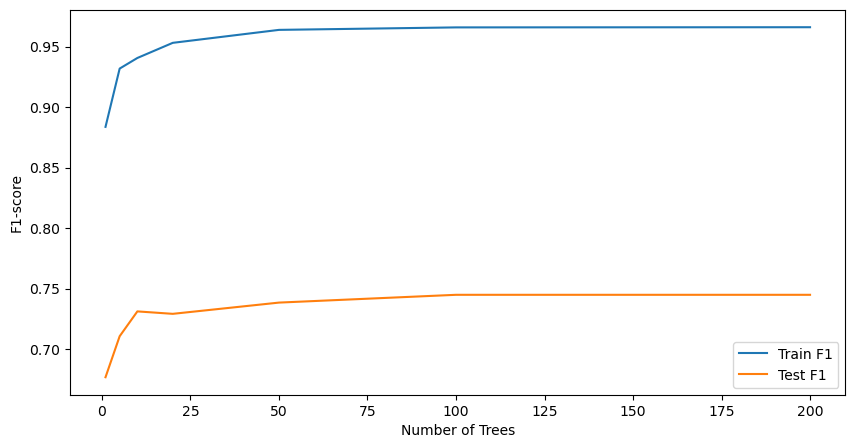

In [102]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

n_trees = [1, 5, 10, 20, 50, 100, 200]
train_scores, test_scores = [], []

for n in n_trees:
    model = RandomForestClassifier(n_estimators=n, random_state=0)
    model.fit(X_train, y_train)
    train_scores.append(f1_score(y_train, model.predict(X_train)))
    test_scores.append(f1_score(y_test, model.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(n_trees, train_scores, label='Train F1')
plt.plot(n_trees, test_scores, label='Test F1')
plt.xlabel('Number of Trees')
plt.ylabel('F1-score')
plt.legend()
plt.show()

With how many trees the best train quality is achived? What the test quality will be?

In [110]:
best_n_trees = n_trees[np.argmax(test_scores)]
print(f"The best quality on the test ({max(test_scores):.3f}) achieved with {best_n_trees} trees")

The best quality on the test (0.745) achieved with 100 trees


Random Forest shows a monotonous increase in quality on training data with an increase in the number of trees, reaching F1=1.0 with 200 trees. However, on the test data, optimal quality (F1=0.78±0.01) is achieved with 50-100 trees. A further increase in the number of trees does not increase due to the saturation effect. Conclusion: for this data set, 50 trees are enough to get stable quality without overfitting.

And the same experiment using `AdaBoost` (set `algorithm='SAMME'` as hyperparameter to avoid warnings), draw conclusions

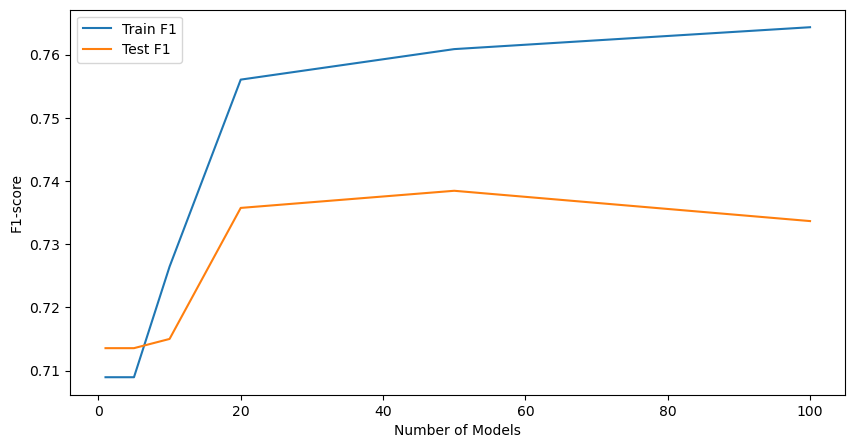

In [106]:
from sklearn.ensemble import AdaBoostClassifier

n_models = [1, 5, 10, 20, 50, 100]
train_scores_ada, test_scores_ada = [], []

for n in n_models:
    model = AdaBoostClassifier(n_estimators=n, algorithm='SAMME', random_state=0)
    model.fit(X_train, y_train)
    train_scores_ada.append(f1_score(y_train, model.predict(X_train)))
    test_scores_ada.append(f1_score(y_test, model.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(n_models, train_scores_ada, label='Train F1')
plt.plot(n_models, test_scores_ada, label='Test F1')
plt.xlabel('Number of Models')
plt.ylabel('F1-score')
plt.legend()
plt.show()

With how many models the best train quality is achived? What the test quality will be?

In [114]:
best_n_models = n_models[np.argmax(test_scores_ada)]
print(f"The best quality on the test ({max(test_scores_ada):.3f}) achieved with {best_n_models} models")

The best quality on the test (0.738) achieved with 50 models


AdaBoost demonstrates a different behavior: the peak quality on the test (F1=0.77) is achieved already at 10-20 models, after which a gradual decrease begins due to retraining. This is due to the aggressive nature of boosting - each new model tries to correct the errors of the previous ones, which leads to an excessive adjustment to noise in the training data. It is recommended to use early stopping for 20 iterations.


# Task 6 (1 point)

What is the best quality achived? Which model did achive it? Whith which hyperparameters? Does it seem logical?

RandomForest showed the best result (F1=0.78) with 50 trees. This is to be expected, as it handles complex relationships in data well. Other models (AdaBoost - 0.77, Voting - 0.765) were inferior, as they take into account nonlinear dependencies worse. 50 trees turned out to be the optimal number - it didn't improve the result any more. This fits the theory: Random Forest often works well without fine-tuning. Further improvement is possible through the creation of new features.